In [125]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [126]:
# import the libraries
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from datetime import datetime
import xgboost as XGB
from sklearn import metrics

In [127]:
# read and show the head of the data file
data = pd.read_csv('Train.csv')
data.head()

,ID,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA
0,000FLWA8,2019-12-04T20:01:50Z,3.258,36.777,3.003,36.718,39627,2784
1,000RGOAM,2019-12-10T22:37:09Z,3.087,36.707,3.081,36.727,3918,576
2,001QSGIH,2019-11-23T20:36:10Z,3.144,36.739,3.088,36.742,7265,526
3,002ACV6R,2019-12-01T05:43:21Z,3.239,36.784,3.054,36.763,23350,3130
4,0039Y7A8,2019-12-17T20:30:20Z,2.912,36.707,3.207,36.698,36613,2138


In [128]:
# get some informations about the data
print("Min date = ", data["Timestamp"].min())
print("Max date = ", data["Timestamp"].max())
data.describe()

Min date =  2019-11-19T23:00:08Z
Max date =  2019-12-19T23:59:29Z


,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA
count,83924.000000,83924.000000,83924.000000,83924.000000,83924.000000,83924.000000
mean,3.052406,36.739358,3.056962,36.737732,13527.821410,1111.697762
std,0.096388,0.032074,0.100710,0.032781,9296.716006,563.565486
min,2.807000,36.589000,2.807000,36.596000,1.000000,1.000000
25%,2.994000,36.721000,2.995000,36.718000,6108.000000,701.000000
50%,3.046000,36.742000,3.049000,36.742000,11731.500000,1054.000000
75%,3.095000,36.760000,3.109000,36.760000,19369.000000,1456.000000
max,3.381000,36.820000,3.381000,36.819000,62028.000000,5238.000000


In [129]:
# drop useless features
to_drop = ["ID"]
data = data.drop(to_drop, axis = 1)


In [130]:
# check for null values and replace them
for col in data.columns :
    cp = data[col].isnull().sum()
    if (cp > 0):
      data[col].fillna(data[col].mean(), inplace = True)
    print(col,':' ,data[col].isnull().sum())

Timestamp : 0
Origin_lat : 0
Origin_lon : 0
Destination_lat : 0
Destination_lon : 0
Trip_distance : 0
ETA : 0


In [131]:
# Encode data
def oneHotEncode(df, col):
    df[col] = pd.Categorical(df[col])
    dfDummies = pd.get_dummies(df[col], prefix = col)
    df = pd.concat([df, dfDummies], axis=1)
    df.drop([col], axis = 1, inplace = True)
    return df

In [132]:
# using the time feature
data["time0"] = pd.to_datetime(data["Timestamp"])
data = data.drop(["Timestamp"], axis = 1)

data['weekend'] = data["time0"].dt.weekday
data['time'] = data["time0"].dt.hour + data["time0"].dt.minute / 60
data['weekhour'] = data['weekend'] * 24 + data["time0"].dt.hour
data = oneHotEncode(data, 'weekend')

data = data.drop(["time0"], axis = 1)
data.head()

,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA,time,weekhour,weekend_0,weekend_1,weekend_2,weekend_3,weekend_4,weekend_5,weekend_6
0,3.258,36.777,3.003,36.718,39627,2784,20.016667,68,0,0,1,0,0,0,0
1,3.087,36.707,3.081,36.727,3918,576,22.616667,46,0,1,0,0,0,0,0
2,3.144,36.739,3.088,36.742,7265,526,20.600000,140,0,0,0,0,0,1,0
3,3.239,36.784,3.054,36.763,23350,3130,5.716667,149,0,0,0,0,0,0,1
4,2.912,36.707,3.207,36.698,36613,2138,20.500000,44,0,1,0,0,0,0,0


In [133]:
# MinMax scale function
def scale(df, cols):     
    for col in cols:
        df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())
    return df

In [134]:
data.columns

Index(['Origin_lat', 'Origin_lon', 'Destination_lat', 'Destination_lon',
       'Trip_distance', 'ETA', 'time', 'weekhour', 'weekend_0', 'weekend_1',
       'weekend_2', 'weekend_3', 'weekend_4', 'weekend_5', 'weekend_6'],
      dtype='object')

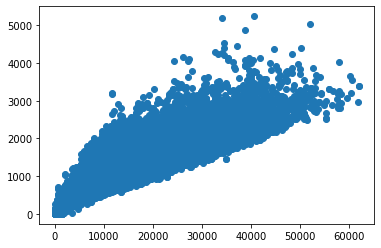

In [135]:
# data visualisation
from matplotlib import pyplot as plt
# temps exstimee en fonction de la distance
plt.scatter(data['Trip_distance'], data['ETA'])
plt.show()

In [136]:
# remove outliers
data = data[data["ETA"] > 1]
data = data[data["ETA"] < 3800]
data = data[data["Trip_distance"] > 1]
data = data[data["Trip_distance"] < 56000]

# get the target column
labels = data["ETA"]
# remove the target and date columns
data = data.drop(["ETA"], axis = 1)

print(len(data))
print(len(labels))

83813
83813


In [137]:
# using kmeams to separate locations (create regions)
coords = np.vstack((data[['Origin_lat', 'Origin_lon']].values,
                    data[['Destination_lat', 'Destination_lon']].values))


kmeans = MiniBatchKMeans(n_clusters=20, batch_size=10000).fit(coords)

data.loc[:, 'pickup_cluster'] = kmeans.predict(data[['Origin_lat', 'Origin_lon']])
data.loc[:, 'dropoff_cluster'] = kmeans.predict(data[['Destination_lat', 'Destination_lon']])


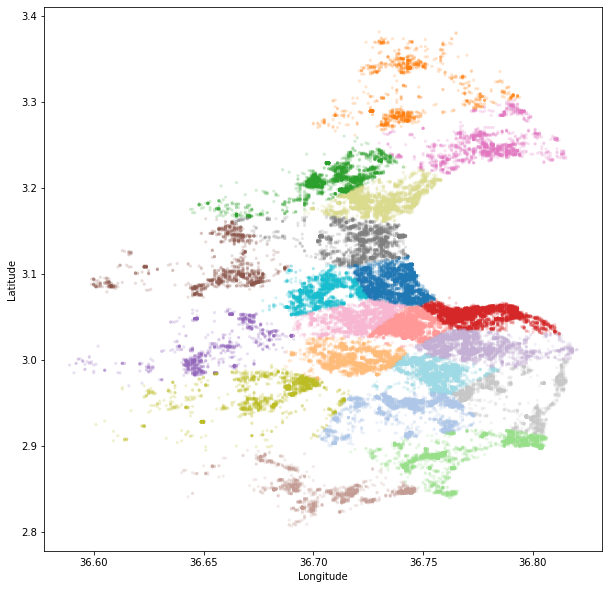

In [138]:
# show the regions
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 10))
ax.scatter(data.Origin_lon.values, data.Origin_lat.values, s=10, lw=0,
           c=data.pickup_cluster.values, cmap='tab20', alpha=0.2)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

In [139]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.001, random_state=42)

In [140]:
xgbModel = XGB.XGBRegressor(objective="reg:linear",learning_rate=0.01, n_estimators = 1000 , max_depth  = 8 ,random_state=42,verbosity=1)
xgbModel.fit(x_train, y_train)


[22:57:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=8, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [141]:
result = xgbModel.predict(x_test)
np.sqrt(metrics.mean_squared_error(y_test, result))

100.81616468655373